# Setup

In [ ]:
!wget -O data.csv https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv

--2022-03-20 13:27:28--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453908 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.39M  --.-KB/s    in 0.06s   

2022-03-20 13:27:28 (24.3 MB/s) - ‘data.csv’ saved [1453908/1453908]



In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!"{sys.executable}" -m pip install fbprophet

/bin/bash: {sys.executable}: command not found


In [ ]:

from fbprophet import Prophet


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import plotly.express as px

# Analyzing data

In [ ]:
data = pd.read_csv('data.csv', header=0, parse_dates=['date'])

In [ ]:
data.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [ ]:
print(f"{data.shape[0]} records")

41278 records


In [ ]:
data = data[data["state"]=="California"]

In [ ]:
data.drop(["state", "fips", "deaths", ], axis=1, inplace=True)
data = data.reset_index(drop=True)

In [ ]:
data = data.rename(columns={'date':'ds', 'cases':'y'})

In [ ]:
print(f"{data.shape[0]} records after filtering")

785 records after filtering


In [ ]:
data.head()


,ds,y
0,2020-01-25,1
1,2020-01-26,2
2,2020-01-27,2
3,2020-01-28,2
4,2020-01-29,2


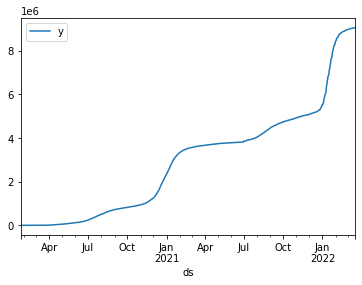

In [ ]:
data.plot(x="ds", y="y")
plt.show()

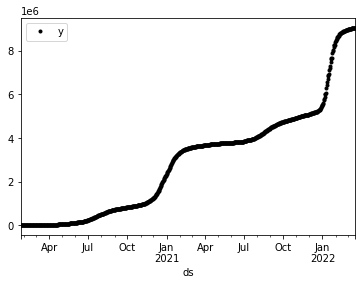

In [ ]:
data.plot(x="ds", y="y", style='k.')
plt.show()

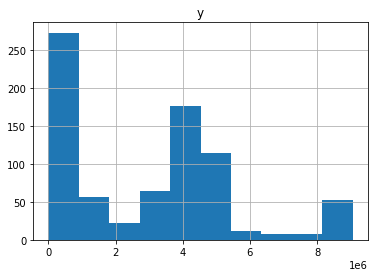

In [ ]:
data.hist(column=["y"])
plt.show()

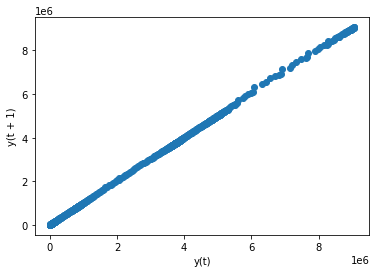

In [ ]:
from pandas.plotting import lag_plot
lag_plot(data.y)
plt.show()

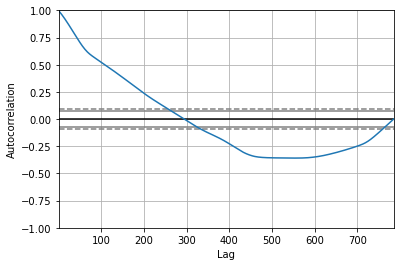

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data.y)
plt.show()

# Forecast

I've used Facebook Prophet to generate the time-series model. Facebook Prophet is particularly good at modeling multiple seasonalities, which although is not required here.  It also uses a default list of US holidays and adds/subtracts values based on historical data for those holidays.

In [ ]:
m = Prophet(changepoint_range = 1, changepoint_prior_scale=0.03, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True) 
m = m.fit(data) # We fit the model to the data


I think that there is no annual and daily seasonality because of the nature of the data. I believe that there might be weekly seasonaligy and holiday disturbances, which can be easily captured by Facebook Prophet. I've set the parameters accordingly.

In [ ]:
future = m.make_future_dataframe(periods=365) # we want the forecast for the next 365 days.

future.tail()

,ds
1145,2023-03-15
1146,2023-03-16
1147,2023-03-17
1148,2023-03-18
1149,2023-03-19


In [ ]:
forecast = m.predict(future)


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() # some interpretable parameters

,ds,yhat,yhat_lower,yhat_upper
1145,2023-03-15,1.711179e+07,1.081822e+07,2.305486e+07
1146,2023-03-16,1.713962e+07,1.078352e+07,2.307516e+07
1147,2023-03-17,1.716190e+07,1.070053e+07,2.313385e+07
1148,2023-03-18,1.718061e+07,1.077427e+07,2.321986e+07
1149,2023-03-19,1.720044e+07,1.075926e+07,2.323523e+07


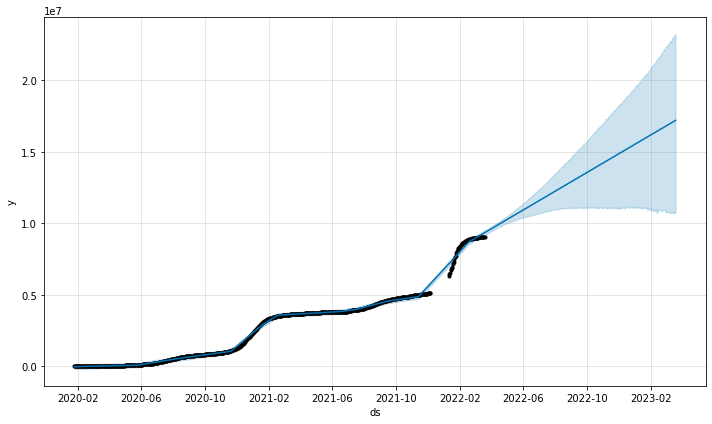

In [ ]:
fig1 = m.plot(forecast) 


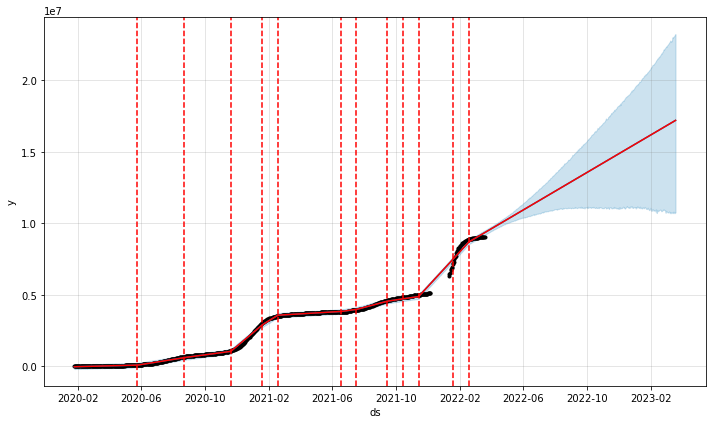

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig1.gca(), m, forecast) # We want to see the changepoints 
fig1


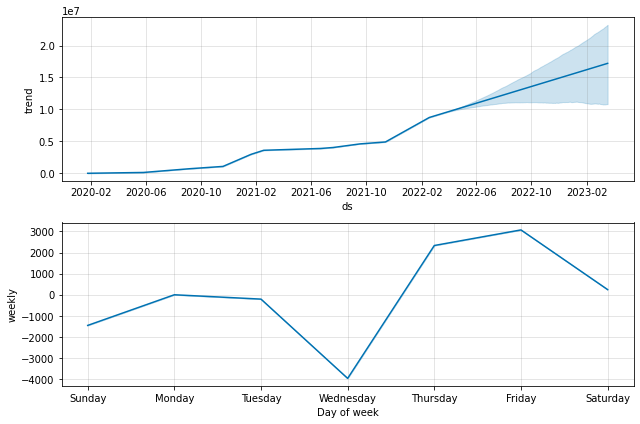

In [ ]:
fig2 = m.plot_components(forecast)


We can see that the model forecasts 10M cases on 19 April 2022 with an error margin of 2.14%

In [ ]:
forecast[forecast['ds']=='2022-04-19']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
815,2022-04-19,1.000895e+07,9.786282e+06,1.021420e+07,9.897902e+06,1.010411e+07,-211.051799,-211.051799,-211.051799,-211.051799,-211.051799,-211.051799,0.0,0.0,0.0,1.000874e+07


# Evaluation

I evaluate the model using cross validation. I start with 480 days of initial training data. After this, I make predictions every 50 days on a horizon of 100 days. This corresponds to 5 forecasts as of 20th March 2022.

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='480 days', period='50 days', horizon = '100 days') 


INFO:fbprophet:Making 5 forecasts with cutoffs between 2021-05-23 00:00:00 and 2021-12-09 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv) # We want to see the performance metrics. To know more about the individual metrics, https://facebook.github.io/prophet/docs/diagnostics.html
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,coverage
0,10 days,8.937034e+07,9453.588811,7282.542130,0.001594,0.001222,0.96
1,11 days,1.278050e+08,11305.088857,8383.230359,0.001828,0.001300,0.92
2,12 days,1.829522e+08,13525.982403,9861.301128,0.002139,0.001430,0.88
3,13 days,2.460869e+08,15687.157589,11470.597916,0.002476,0.001989,0.84
4,14 days,3.477868e+08,18649.041939,13555.129363,0.002924,0.002204,0.80


In [ ]:
df_p.iloc[30] # forecast 30 days into the future

horizon        40 days 00:00:00
mse         413206319416.945435
rmse              642811.262671
mae               352041.411733
mape                   0.057766
mdape                  0.034551
coverage                    0.4
Name: 30, dtype: object

We can see that the typical errors are 5% for a forecast 30 days into the future.

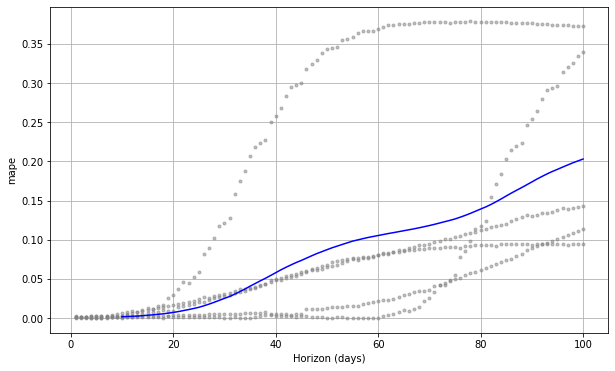

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape') # We've plotted the Mean Absolute Percent Error for forecasts into different periods into the future.


# Outlier Detection

I first try to detect outliers based on visual inspection of the time series plot. I don't find any.

I try to detect the outliers based on the uncertainties returned by fb-prophet. I will then decide how the outliers should be treated. 

In [ ]:
m = Prophet(changepoint_range = 0.8, changepoint_prior_scale=0.05, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)
train_data = data
m.fit(train_data)

future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

In [ ]:
result = pd.concat([data.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)


In [ ]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [ ]:
# We call a sample outlier if it lies outside the model's uncertainty band
result['outlier'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > x['uncertainty']) else 'No', axis = 1)


In [ ]:
# Using plotly for plotting
fig = px.scatter(result.reset_index(), x='ds', y='y', color='outlier', title='Covid Cases in Calfornia')
# Using plotly sliders
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1m', step="month", stepmode="backward"),
              dict(count=2, label='3m', step="month", stepmode="backward"),
              dict(count=2, label='5m', step="month", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

It can be seen that the data from 24 Dec 2021 till 10 Jan 2022 and from 21 Jan 2022 till 6 Feb 2022 are not fitted correctly because of an inflection points there. 


In [ ]:
data.loc[pd.Series(result.outlier=="Yes").values, 'y'] = None


To improve the predictive power of prophet, I remove the outliers.

# Analysing Residuals

I plot the residuals with time.

In [ ]:
result.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,outlier
ds,,,,,,,
2020-01-25,1.0,-66776.233162,-400274.087611,302700.201688,66777.233162,702974.289299,No
2020-01-26,2.0,-68946.837089,-419500.975678,256843.389461,68948.837089,676344.365139,No
2020-01-27,2.0,-62106.964825,-390064.707535,275099.604669,62108.964825,665164.312204,No
2020-01-28,2.0,-61001.908222,-406090.434676,284200.859421,61003.908222,690291.294097,No
2020-01-29,2.0,-66188.835836,-422216.674980,286400.324267,66190.835836,708616.999247,No


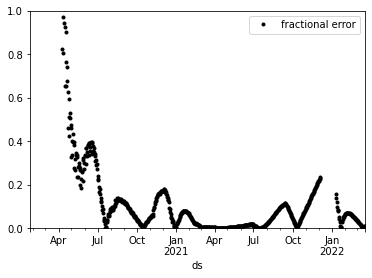

In [ ]:
result["fractional error"] = result["error"].abs() / (result["y"] + 2)

result.plot(y="fractional error", style='k.') # Plotting the fractional error
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()

The residuals are quite high in the initial time period because of the low predictive capability of the model. We can see that our forecasting grows stronger with time. The residuals are not periodic or seasonal. I can't really think of a way to fit the residuals. 

# Approach 1: Fitting another time series model on the residuals to capture possible seasonality in the residuals. 

In [ ]:
m = Prophet(changepoint_range = 0.8, changepoint_prior_scale=0.05, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True) 
m = m.fit(data) # We fit the model to the data
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

The mean fractional error in fbprophet's forecast for the last 20 days


In [ ]:
sum(abs(forecast["yhat"].iloc[-20:] - data["y"].iloc[-20:])) / sum(data["y"].iloc[-20:])

0.012231576403594903

In [ ]:

residuals = result.copy()
residuals["y"] = result["error"]
residuals["ds"] = result.index

In [ ]:
m_residuals = Prophet(changepoint_range = 0.8, changepoint_prior_scale=0.08, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)

m_residuals.fit(residuals)

future = m_residuals.make_future_dataframe(periods=0)
residual_forecast = m_residuals.predict(future)

In [ ]:
combined_forecast = forecast["yhat"] + 0.1 * residual_forecast["yhat"]

The mean fractional error in combined model's forecast for the last 50 days

In [ ]:
sum(abs(combined_forecast.iloc[-20:] - data["y"].iloc[-20:])) / sum(data["y"].iloc[-20:])

0.01223579526584672

We can see that the combined model cannot correct the residuals and the mean fractional error stays the same.

# Approach 2: Increasing the sensitivity of fb prophet model

In [ ]:
from fbprophet.diagnostics import cross_validation
m_increased_sensivity = Prophet(changepoint_range = 1, changepoint_prior_scale=0.06, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)
m_increased_sensivity.fit(data)
df_cv = cross_validation(m_increased_sensivity, initial='480 days', period='50 days', horizon = '100 days') 


INFO:fbprophet:Making 5 forecasts with cutoffs between 2021-05-23 00:00:00 and 2021-12-09 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,coverage
0,11 days,1.103239e+08,10503.516254,7033.108369,0.001608,0.001065,0.904762
1,12 days,1.538114e+08,12402.073222,8190.040909,0.001864,0.001081,0.880952
2,13 days,1.941030e+08,13932.087028,9300.347203,0.002112,0.001218,0.857143
3,14 days,2.529282e+08,15903.715833,10808.959299,0.002459,0.001441,0.833333
4,15 days,3.276988e+08,18102.452283,12549.580464,0.002862,0.001653,0.809524


In [ ]:
df_p.iloc[30]

horizon        41 days 00:00:00
mse         531621402129.802551
rmse              729123.722101
mae               401055.458213
mape                    0.06422
mdape                   0.03845
coverage               0.528571
Name: 30, dtype: object

We can see that the typical errors have increased to 6% for a forecast 30 days into the future.

# Redoing Prediction after removing outliers

In [ ]:
m = Prophet(changepoint_range = 1, changepoint_prior_scale=0.05, daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=True)
m = m.fit(data)


I think that there is no annual and daily seasonality because of the nature of the data. I've set the parameters accordingly.

In [ ]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
879,2022-06-22
880,2022-06-23
881,2022-06-24
882,2022-06-25
883,2022-06-26


In [ ]:
forecast = m.predict(future)


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
879,2022-06-22,9.324063e+06,7.734338e+06,1.066042e+07
880,2022-06-23,9.328903e+06,7.697183e+06,1.065674e+07
881,2022-06-24,9.333613e+06,7.666930e+06,1.070160e+07
882,2022-06-25,9.334557e+06,7.651154e+06,1.074380e+07
883,2022-06-26,9.339351e+06,7.611085e+06,1.078326e+07


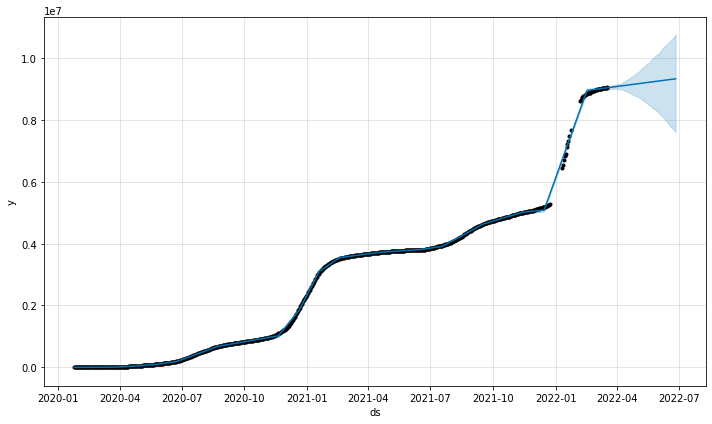

In [ ]:
fig1 = m.plot(forecast)


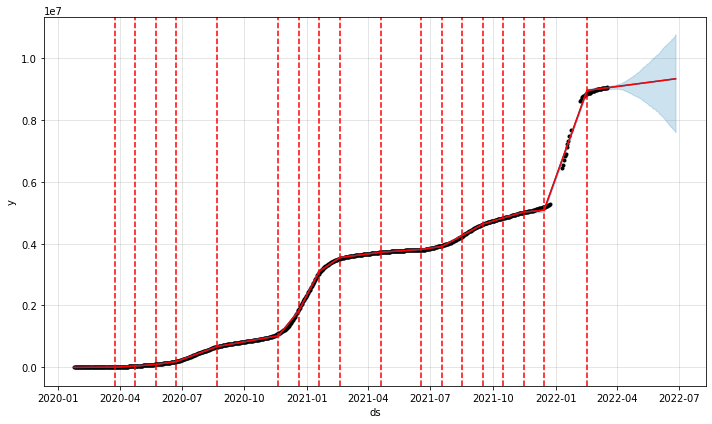

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig1


# Live Production

I checkpoint/store trained models with training data upto every point of time in the past 60 days.

For every day in live production, I make predictions using models checkpointed 10 days, 20 days, ..., 60 days ago. This would give me a fair assessment of model performance. 

I aggregate the model performance metrics using each of the 6 checkpointed models to get an aggregated model performance metric. E.g. I might take a mean of the MAPE (Mean Absolute Percent Error) for the models in consideration.

I retrain the model on the complete dataset every single day in live production. 